<a href="https://colab.research.google.com/github/Abhilitcode/DaveAI_Internship/blob/main/main/_downloads/454ce4c8debdfeda1ab0ab945c52976d/forced_alignment_for_multilingual_data_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Forced alignment for multilingual data

**Authors**: [Xiaohui Zhang](xiaohuizhang@meta.com)_, [Moto Hira](moto@meta.com)_.

This tutorial shows how to align transcript to speech for non-English languages.

The process of aligning non-English (normalized) transcript is identical to aligning
English (normalized) transcript, and the process for English is covered in detail in
[CTC forced alignment tutorial](./ctc_forced_alignment_api_tutorial.html)_.
In this tutorial, we use TorchAudio's high-level API,
:py:class:`torchaudio.pipelines.Wav2Vec2FABundle`, which packages the pre-trained
model, tokenizer and aligner, to perform the forced alignment with less code.


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.4.1+cu121
2.4.1+cu121
cpu


In [2]:
from typing import List

import IPython
import matplotlib.pyplot as plt

## Creating the pipeline

First, we instantiate the model and pre/post-processing pipelines.

The following diagram illustrates the process of alignment.

<img src="https://download.pytorch.org/torchaudio/doc-assets/pipelines-wav2vec2fabundle.png">

The waveform is passed to an acoustic model, which produces the sequence of
probability distribution of tokens.
The transcript is passed to tokenizer, which converts the transcript to
sequence of tokens.
Aligner takes the results from the acoustic model and the tokenizer and generate
timestamps for each token.

<div class="alert alert-info"><h4>Note</h4><p>This process expects that the input transcript is already normalized.
   The process of normalization, which involves romanization of non-English
   languages, is language-dependent, so it is not covered in this tutorial,
   but we will breifly look into it.</p></div>

The acoustic model and the tokenizer must use the same set of tokens.
To facilitate the creation of matching processors,
:py:class:`~torchaudio.pipelines.Wav2Vec2FABundle` associates a
pre-trained accoustic model and a tokenizer.
:py:data:`torchaudio.pipelines.MMS_FA` is one of such instance.

The following code instantiates a pre-trained acoustic model, a tokenizer
which uses the same set of tokens as the model, and an aligner.




In [3]:
from torchaudio.pipelines import MMS_FA as bundle

model = bundle.get_model()
model.to(device)

tokenizer = bundle.get_tokenizer()
aligner = bundle.get_aligner()

Downloading: "https://dl.fbaipublicfiles.com/mms/torchaudio/ctc_alignment_mling_uroman/model.pt" to /root/.cache/torch/hub/checkpoints/model.pt
100%|██████████| 1.18G/1.18G [00:05<00:00, 246MB/s]


<div class="alert alert-info"><h4>Note</h4><p>The model instantiated by :py:data:`~torchaudio.pipelines.MMS_FA`'s
   :py:meth:`~torchaudio.pipelines.Wav2Vec2FABundle.get_model`
   method by default includes the feature dimension for ``<star>`` token.
   You can disable this by passing ``with_star=False``.</p></div>




The acoustic model of :py:data:`~torchaudio.pipelines.MMS_FA` was
created and open-sourced as part of the research project,
[Scaling Speech Technology to 1,000+ Languages](https://research.facebook.com/publications/scaling-speech-technology-to-1000-languages/)_.
It was trained with 23,000 hours of audio from 1100+ languages.

The tokenizer simply maps the normalized characters to integers.
You can check the mapping as follow;



In [4]:
print(bundle.get_dict())

{'-': 0, 'a': 1, 'i': 2, 'e': 3, 'n': 4, 'o': 5, 'u': 6, 't': 7, 's': 8, 'r': 9, 'm': 10, 'k': 11, 'l': 12, 'd': 13, 'g': 14, 'h': 15, 'y': 16, 'b': 17, 'p': 18, 'w': 19, 'c': 20, 'v': 21, 'j': 22, 'z': 23, 'f': 24, "'": 25, 'q': 26, 'x': 27, '*': 28}


The aligner internally uses :py:func:`torchaudio.functional.forced_align`
and :py:func:`torchaudio.functional.merge_tokens` to infer the time
stamps of the input tokens.

The detail of the underlying mechanism is covered in
[CTC forced alignment API tutorial](./ctc_forced_alignment_api_tutorial.html)_,
so please refer to it.



We define a utility function that performs the forced alignment with
the above model, the tokenizer and the aligner.




In [5]:
def compute_alignments(waveform: torch.Tensor, transcript: List[str]):
    with torch.inference_mode():
        emission, _ = model(waveform.to(device))
        token_spans = aligner(emission[0], tokenizer(transcript)) #aligner is helping us to generate token spans
    return emission, token_spans

In [ ]:
print(emission)

NameError: name 'emission' is not defined

In [ ]:
print(emission.size(1))

124


In [ ]:
print(token_spans)

[[TokenSpan(token=1, start=11, end=12, score=0.9904037714004517), TokenSpan(token=17, start=16, end=17, score=0.8990506529808044), TokenSpan(token=3, start=19, end=20, score=0.9892625212669373), TokenSpan(token=9, start=22, end=23, score=0.9785522818565369)], [TokenSpan(token=8, start=28, end=29, score=0.985653281211853), TokenSpan(token=3, start=31, end=32, score=0.9621745347976685), TokenSpan(token=2, start=34, end=35, score=0.9627019166946411), TokenSpan(token=7, start=37, end=38, score=0.20485244691371918)], [TokenSpan(token=2, start=42, end=43, score=0.947116494178772), TokenSpan(token=20, start=45, end=46, score=0.9715186357498169), TokenSpan(token=15, start=46, end=47, score=0.8045710325241089)], [TokenSpan(token=17, start=51, end=52, score=0.953883945941925), TokenSpan(token=3, start=54, end=55, score=0.9583654403686523), TokenSpan(token=2, start=58, end=59, score=0.9552595615386963)], [TokenSpan(token=2, start=66, end=67, score=0.8190262913703918), TokenSpan(token=15, start=69

We also define utility functions for plotting the result and previewing
the audio segments.



In [6]:
# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start, t_spans[-1].end
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
        axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    fig.tight_layout()

In [7]:
def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)
    print(x0)

## Normalizing the transcript

The transcripts passed to the pipeline must be normalized beforehand.
The exact process of normalization depends on language.

Languages that do not have explicit word boundaries
(such as Chinese, Japanese and Korean) require segmentation first.
There are dedicated tools for this, but let's say we have segmented
transcript.

The first step of normalization is romanization.
[uroman](https://github.com/isi-nlp/uroman)_ is a tool that
supports many languages.

Here is a BASH commands to romanize the input text file and write
the output to another text file using ``uroman``.

```bash
$ echo "des événements d'actualité qui se sont produits durant l'année 1882" > text.txt
$ uroman/bin/uroman.pl < text.txt > text_romanized.txt
$ cat text_romanized.txt
```
```text
Cette page concerne des evenements d'actualite qui se sont produits durant l'annee 1882
```
The next step is to remove non-alphabets and punctuations.
The following snippet normalizes the romanized transcript.

```python
import re


def normalize_uroman(text):
    text = text.lower()
    text = text.replace("’", "'")
    text = re.sub("([^a-z' ])", " ", text)
    text = re.sub(' +', ' ', text)
    return text.strip()


with open("text_romanized.txt", "r") as f:
    for line in f:
        text_normalized = normalize_uroman(line)
        print(text_normalized)
```
Running the script on the above exanple produces the following.

```text
cette page concerne des evenements d'actualite qui se sont produits durant l'annee
```
Note that, in this example, since "1882" was not romanized by ``uroman``,
it was removed in the normalization step.
To avoid this, one needs to romanize numbers, but this is known to be a non-trivial task.




## Aligning transcripts to speech

Now we perform the forced alignment for multiple languages.


### German



In [8]:
text_raw = "aber seit ich bei ihnen das brot hole"
text_normalized = "aber seit ich bei ihnen das brot hole"

url = "https://download.pytorch.org/torchaudio/tutorial-assets/10349_8674_000087.flac"
waveform, sample_rate = torchaudio.load(
    url, frame_offset=int(0.5 * bundle.sample_rate), num_frames=int(2.5 * bundle.sample_rate)
)

In [9]:
assert sample_rate == bundle.sample_rate

Raw Transcript:  aber seit ich bei ihnen das brot hole
Normalized Transcript:  aber seit ich bei ihnen das brot hole


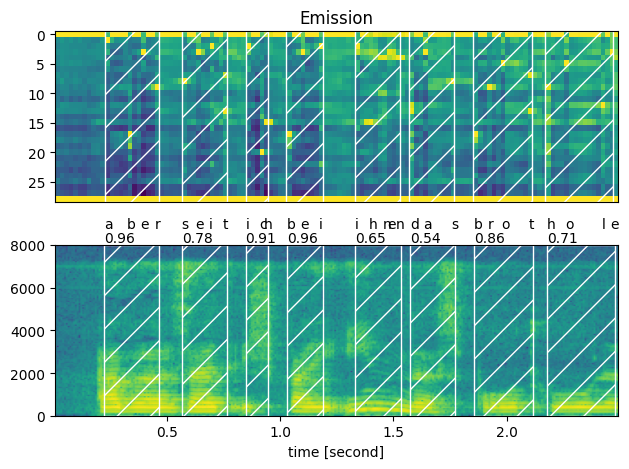

In [10]:
transcript = text_normalized.split()
tokens = tokenizer(transcript)

emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [ ]:
print(waveform)

tensor([[ 3.0518e-05, -3.0518e-05,  0.0000e+00,  ..., -3.2288e-02,
         -3.1372e-02, -2.9205e-02]])


In [ ]:
print(waveform.size(1))

40000


In [ ]:
print(len(token_spans))

8


In [ ]:
print(len(token_spans[2]))

3


In [ ]:
print(num_frames)

124


In [ ]:
print(sample_rate) #needed to convert sample indices to seconds

16000


In [ ]:
def preview_all_words(waveform, words_spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    print("Words Spans: ", words_spans)  # Inspect the structure of words_spans

    ratio = waveform.size(1) / num_frames
    all_segments = []

    # Iterate over each word's spans
    for word_idx, word_spans in enumerate(words_spans):
        print(f"Processing word '{transcript[word_idx]}':")

        word_segments = []
        for span in word_spans:
            x0 = int(ratio * span.start)
            x1 = int(ratio * span.end)
            word_segments.append((x0, x1))

        for idx, (x0, x1) in enumerate(word_segments):
            segment = waveform[:, x0:x1]
            start_time = x0 / sample_rate
            end_time = x1 / sample_rate
            print(f"Character '{transcript[word_idx][idx]}': {start_time:.3f} - {end_time:.3f} sec")


        all_segments.append(word_segments)

    return all_segments



In [11]:
def extract_word_timestamps(waveform, token_spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    # word_timestamps = []

    for t_spans, word in zip(token_spans, transcript):
        start_time = t_spans[0].start * ratio / sample_rate
        end_time = t_spans[-1].end * ratio / sample_rate
        # word_timestamps.append((word, start_time, end_time))
        print(f"Word: '{word}', Start: {start_time:.3f} sec, End: {end_time:.3f} sec")

    # return word_timestamps


In [ ]:
extract_word_timestamps(waveform, token_spans, num_frames, transcript)

Word: 'aber', Start: 0.222 sec, End: 0.464 sec
Word: 'seit', Start: 0.565 sec, End: 0.766 sec
Word: 'ich', Start: 0.847 sec, End: 0.948 sec
Word: 'bei', Start: 1.028 sec, End: 1.190 sec
Word: 'ihnen', Start: 1.331 sec, End: 1.532 sec
Word: 'das', Start: 1.573 sec, End: 1.774 sec
Word: 'brot', Start: 1.855 sec, End: 2.117 sec
Word: 'hole', Start: 2.177 sec, End: 2.480 sec


In [ ]:
preview_all_words(waveform, token_spans, num_frames, transcript)

Words Spans:  [[TokenSpan(token=1, start=11, end=12, score=0.9904037714004517), TokenSpan(token=17, start=16, end=17, score=0.8990506529808044), TokenSpan(token=3, start=19, end=20, score=0.9892625212669373), TokenSpan(token=9, start=22, end=23, score=0.9785522818565369)], [TokenSpan(token=8, start=28, end=29, score=0.985653281211853), TokenSpan(token=3, start=31, end=32, score=0.9621745347976685), TokenSpan(token=2, start=34, end=35, score=0.9627019166946411), TokenSpan(token=7, start=37, end=38, score=0.20485244691371918)], [TokenSpan(token=2, start=42, end=43, score=0.947116494178772), TokenSpan(token=20, start=45, end=46, score=0.9715186357498169), TokenSpan(token=15, start=46, end=47, score=0.8045710325241089)], [TokenSpan(token=17, start=51, end=52, score=0.953883945941925), TokenSpan(token=3, start=54, end=55, score=0.9583654403686523), TokenSpan(token=2, start=58, end=59, score=0.9552595615386963)], [TokenSpan(token=2, start=66, end=67, score=0.8190262913703918), TokenSpan(toke

[[(3548, 3870), (5161, 5483), (6129, 6451), (7096, 7419)],
 [(9032, 9354), (10000, 10322), (10967, 11290), (11935, 12258)],
 [(13548, 13870), (14516, 14838), (14838, 15161)],
 [(16451, 16774), (17419, 17741), (18709, 19032)],
 [(21290, 21612),
  (22258, 22580),
  (23225, 23548),
  (23548, 23870),
  (24193, 24516)],
 [(25161, 25483), (26129, 26451), (28064, 28387)],
 [(29677, 30000), (30645, 30967), (31612, 31935), (33548, 33870)],
 [(34838, 35161), (36129, 36451), (38709, 39032), (39354, 39677)]]

In [ ]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

aber (0.96): 0.222 - 0.464 sec


In [ ]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

seit (0.78): 0.565 - 0.766 sec


In [ ]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

ich (0.91): 0.847 - 0.948 sec


In [ ]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

bei (0.96): 1.028 - 1.190 sec


In [ ]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

ihnen (0.65): 1.331 - 1.532 sec


In [ ]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

das (0.54): 1.573 - 1.774 sec


In [ ]:
preview_word(waveform, token_spans[6], num_frames, transcript[6])

brot (0.86): 1.855 - 2.117 sec


In [ ]:
preview_word(waveform, token_spans[7], num_frames, transcript[7])

hole (0.71): 2.177 - 2.480 sec


ARABIC

In [12]:
!pip install mishkal

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.5/789.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.6/332.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.3/264.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
!pip install uroman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.7/930.7 kB 20.8 MB/s eta 0:00:00


In [14]:
import uroman

In [15]:
ur = uroman.Uroman()

In [52]:
from mishkal.tashkeel import TashkeelClass
import subprocess
vocalizer = TashkeelClass()
arabic_text = "ذهب الطبيب إلى المستشفى"

diacritized_text = vocalizer.tashkeel(arabic_text)

Exception ignored in: <function ArabicDictionary.__del__ at 0x7d51fb4f2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/arramooz/arabicdictionary.py", line 109, in __del__
    self.db_connect.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 137797619945472 and this is thread id 137797071513152.
Exception ignored in: <function ArabicDictionary.__del__ at 0x7d51fb4f2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/arramooz/arabicdictionary.py", line 109, in __del__
    self.db_connect.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 137797619945472 and this is thread id 137797071513152.
Exception ignored in: <function SemanticDictionary.__del__ at 0x7d523e083910>
Traceback (most recent call last):
  File "/usr/local/lib/python

In [17]:
# Install requests if necessary
!pip install requests

API FOR GETTING MALE AND FEMALE ARABIC AUDIO

In [53]:
import requests

# Define the URL and headers for the API request
url = 'https://synthesis-dev.iamdave.ai/synthesizer'
headers = {
    'X-I2CE-API-KEY': 'f30339d5-87a9-3a90-bb13-73140ffe9363',
    'X-I2CE-USER-ID': 'ananth+dave_synthesis@i2ce.in',
    'X-I2CE-ENTERPRISE-ID': 'dave_synthesis',
    'Content-Type': 'application/json'
}

# Change the utterance to something else
data = {
    "utterance": "ذهب الطبيب إلى المستشفى",
    "voice_id": "arabic-female",
    "channels": ["voice"]
}

# Make the API request
response = requests.post(url, headers=headers, json=data)

# Print the response details
print("Response Status Code:", response.status_code)
print("Response Headers:", response.headers)
print("Response Text:", response.text)

# Check for success or failure
if response.ok and response.text:
    print("Success:", response.json())
else:
    print("Failed with status code:", response.status_code)
    print("Response Text:", response.text)


Response Status Code: 200
Response Headers: {'Server': 'nginx', 'Date': 'Wed, 09 Oct 2024 06:26:09 GMT', 'Content-Type': 'application/json', 'Content-Length': '150', 'Connection': 'keep-alive', 'Access-Control-Allow-Origin': '*', 'Vary': 'Origin', 'Strict-Transport-Security': 'max-age=31536000'}
Response Text: {"voice":"https://synthesis-dev.iamdave.ai/static/uploads/3475c3e75ab03cd9a53b1bcc78193832/6bd18850a27431b8b15cf167d99e96be_arabic-female/voice.wav"}

Success: {'voice': 'https://synthesis-dev.iamdave.ai/static/uploads/3475c3e75ab03cd9a53b1bcc78193832/6bd18850a27431b8b15cf167d99e96be_arabic-female/voice.wav'}


API FOR GETTING HINDI MALE AND FEMALE AUDIO

In [ ]:
import requests

# Define the URL and headers for the API request
url = 'https://synthesis-dev.iamdave.ai/synthesizer'
headers = {
    'X-I2CE-API-KEY': 'f30339d5-87a9-3a90-bb13-73140ffe9363',
    'X-I2CE-USER-ID': 'ananth+dave_synthesis@i2ce.in',
    'X-I2CE-ENTERPRISE-ID': 'dave_synthesis',
    'Content-Type': 'application/json'
}

# Change the utterance to something else
data = {
    "utterance": "मैं मुंबई में रहता था लेकिन हाल ही में मैं बेंगलुरु शिफ्ट हो गया हूं",
    "voice_id": "hindi-male",
    "channels": ["voice"]
}

# Make the API request
response = requests.post(url, headers=headers, json=data)

# Print the response details
print("Response Status Code:", response.status_code)
print("Response Headers:", response.headers)
print("Response Text:", response.text)

# Check for success or failure
if response.ok and response.text:
    print("Success:", response.json())
else:
    print("Failed with status code:", response.status_code)
    print("Response Text:", response.text)

Response Status Code: 200
Response Headers: {'Server': 'nginx', 'Date': 'Mon, 07 Oct 2024 16:17:21 GMT', 'Content-Type': 'application/json', 'Content-Length': '147', 'Connection': 'keep-alive', 'Access-Control-Allow-Origin': '*', 'Vary': 'Origin', 'Strict-Transport-Security': 'max-age=31536000'}
Response Text: {"voice":"https://synthesis-dev.iamdave.ai/static/uploads/3475c3e75ab03cd9a53b1bcc78193832/94fcc43860ec3640b41c9175718cc5d5_hindi-male/voice.wav"}

Success: {'voice': 'https://synthesis-dev.iamdave.ai/static/uploads/3475c3e75ab03cd9a53b1bcc78193832/94fcc43860ec3640b41c9175718cc5d5_hindi-male/voice.wav'}


Testing hindi and arabic both.

In [18]:
import uroman
from mishkal.tashkeel import TashkeelClass
import subprocess
import torchaudio
import re
import requests
import IPython.display as ipd

In [19]:
vocalizer = TashkeelClass()

Exception ignored in: <function ArabicDictionary.__del__ at 0x7d51fb4f2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/arramooz/arabicdictionary.py", line 109, in __del__
    self.db_connect.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 137797619945472 and this is thread id 137797071513152.
Exception ignored in: <function ArabicDictionary.__del__ at 0x7d51fb4f2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/arramooz/arabicdictionary.py", line 109, in __del__
    self.db_connect.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 137797619945472 and this is thread id 137797071513152.
Exception ignored in: <function SemanticDictionary.__del__ at 0x7d523e083910>
Traceback (most recent call last):
  File "/usr/local/lib/python

In [20]:
ur = uroman.Uroman()

In [21]:
#creating a normalized fucntion here
def normalize_uroman(text):
    text = text.lower()
    text = text.replace("’", "'")
    text = re.sub("([^a-z' ])", " ", text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [36]:
!pip install sounddevice


In [49]:
# Function to extract word timestamps
def extract_word_timestamps(waveform, token_spans, num_frames, transcript, sample_rate):
    ratio = waveform.size(1) / num_frames
    for t_spans, word in zip(token_spans, transcript):
        start_time = t_spans[0].start * ratio / sample_rate
        end_time = t_spans[-1].end * ratio / sample_rate
        print(f"Word: '{word}', Start: {start_time:.3f} sec, End: {end_time:.3f} sec")

In [48]:
def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)


In [54]:
# Arabic Processing
arabic_text = "ذهب الطبيب إلى المستشفى"
diacritized_text = vocalizer.tashkeel(arabic_text)
romanized_arabic_text = ur.romanize_string(diacritized_text)
normalized_arabic_text = normalize_uroman(romanized_arabic_text)

In [55]:
print("Diacritized Arabic:", diacritized_text)
print("Romanized Arabic:", romanized_arabic_text)
print("Normalized Romanized Arabic:", normalized_arabic_text) #Hello my name is abhishek --> meaning

Diacritized Arabic:  ذَهَبَ الطَّبِيبُ إِلَى الْمُسْتَشْفَى
Romanized Arabic:  thahaba altabiybu iilaa almustashfaa
Normalized Romanized Arabic: thahaba altabiybu iilaa almustashfaa


In [56]:
arabic_url = "https://synthesis-dev.iamdave.ai/static/uploads/3475c3e75ab03cd9a53b1bcc78193832/6bd18850a27431b8b15cf167d99e96be_arabic-female/voice.wav"
waveform_arabic, sample_rate_arabic = torchaudio.load(arabic_url)

In [57]:
def compute_alignments(waveform: torch.Tensor, transcript: List[str]):
    with torch.inference_mode():
        emission, _ = model(waveform.to(device))
        token_spans = aligner(emission[0], tokenizer(transcript)) #aligner is helping us to generate token spans
    return emission, token_spans

In [58]:
print(emission)

tensor([[[-1.6480e-03, -8.9444e+00, -9.4958e+00,  ..., -1.1995e+01,
          -1.1745e+01,  0.0000e+00],
         [-2.7484e-03, -8.0200e+00, -8.5499e+00,  ..., -1.3204e+01,
          -1.2455e+01,  0.0000e+00],
         [-1.9146e-03, -8.6709e+00, -8.5863e+00,  ..., -1.3455e+01,
          -1.2801e+01,  0.0000e+00],
         ...,
         [-6.0427e-02, -7.2165e+00, -6.5781e+00,  ..., -1.1573e+01,
          -1.1625e+01,  0.0000e+00],
         [-3.6304e+00, -3.6488e+00, -4.1008e+00,  ..., -1.0737e+01,
          -1.1563e+01,  0.0000e+00],
         [-2.3983e-01, -5.2218e+00, -5.0885e+00,  ..., -9.2286e+00,
          -8.9079e+00,  0.0000e+00]]])


In [59]:
print(token_spans)

[[TokenSpan(token=1, start=11, end=12, score=0.9904037714004517), TokenSpan(token=17, start=16, end=17, score=0.8990506529808044), TokenSpan(token=3, start=19, end=20, score=0.9892625212669373), TokenSpan(token=9, start=22, end=23, score=0.9785522818565369)], [TokenSpan(token=8, start=28, end=29, score=0.985653281211853), TokenSpan(token=3, start=31, end=32, score=0.9621745347976685), TokenSpan(token=2, start=34, end=35, score=0.9627019166946411), TokenSpan(token=7, start=37, end=38, score=0.20485244691371918)], [TokenSpan(token=2, start=42, end=43, score=0.947116494178772), TokenSpan(token=20, start=45, end=46, score=0.9715186357498169), TokenSpan(token=15, start=46, end=47, score=0.8045710325241089)], [TokenSpan(token=17, start=51, end=52, score=0.953883945941925), TokenSpan(token=3, start=54, end=55, score=0.9583654403686523), TokenSpan(token=2, start=58, end=59, score=0.9552595615386963)], [TokenSpan(token=2, start=66, end=67, score=0.8190262913703918), TokenSpan(token=15, start=69

In [60]:
transcript_arabic = normalized_arabic_text.split()
emission_arabic, token_spans_arabic = compute_alignments(waveform_arabic, transcript_arabic)
num_frames_arabic = emission_arabic.size(1)


In [61]:
print("Word Timestamps for Arabic:")
extract_word_timestamps(waveform_arabic, token_spans_arabic, num_frames_arabic, transcript_arabic, sample_rate_arabic)

Word Timestamps for Arabic:
Word: 'thahaba', Start: 0.080 sec, End: 0.416 sec
Word: 'altabiybu', Start: 0.456 sec, End: 0.925 sec
Word: 'iilaa', Start: 0.992 sec, End: 1.194 sec
Word: 'almustashfaa', Start: 1.207 sec, End: 1.851 sec


In [62]:
ipd.display(ipd.Audio(waveform_arabic, rate=sample_rate_arabic))

In [63]:
# Example for Arabic word preview:
print("Previewing words for Arabic:")
for word, spans in zip(transcript_arabic, token_spans_arabic):
    audio_segment = preview_word(waveform_arabic, spans, num_frames_arabic, word, sample_rate_arabic)
    ipd.display(audio_segment)

Previewing words for Arabic:
thahaba (0.30): 0.080 - 0.416 sec


altabiybu (0.63): 0.456 - 0.925 sec


iilaa (0.67): 0.992 - 1.194 sec


almustashfaa (0.72): 1.207 - 1.851 sec


Hindi preprocessing

In [64]:
hindi_text = "मैं मुंबई में रहता था लेकिन हाल ही में मैं बेंगलुरु शिफ्ट हो गया हूं"
romanized_hindi_text = ur.romanize_string(hindi_text)
normalized_hindi_text = normalize_uroman(romanized_hindi_text)

print("Romanized Hindi:", romanized_hindi_text)
print("Normalized Romanized Hindi:", normalized_hindi_text)

Romanized Hindi: maim mumbaii mem rahataa thaa lekin haal hii mem maim bemgaluru shiphtta ho gayaa huum
Normalized Romanized Hindi: maim mumbaii mem rahataa thaa lekin haal hii mem maim bemgaluru shiphtta ho gayaa huum


In [65]:
hindi_url = "https://synthesis-dev.iamdave.ai/static/uploads/3475c3e75ab03cd9a53b1bcc78193832/94fcc43860ec3640b41c9175718cc5d5_hindi-male/voice.wav"
waveform_hindi, sample_rate_hindi = torchaudio.load(hindi_url)

In [66]:
# Alignment and timestamps for Hindi
transcript_hindi = normalized_hindi_text.split()
emission_hindi, token_spans_hindi = compute_alignments(waveform_hindi, transcript_hindi)
num_frames_hindi = emission_hindi.size(1)
print("Word Timestamps for Hindi:")
extract_word_timestamps(waveform_hindi, token_spans_hindi, num_frames_hindi, transcript_hindi, sample_rate_hindi)

Word Timestamps for Hindi:
Word: 'maim', Start: 0.067 sec, End: 0.187 sec
Word: 'mumbaii', Start: 0.227 sec, End: 0.562 sec
Word: 'mem', Start: 0.628 sec, End: 0.722 sec
Word: 'rahataa', Start: 0.762 sec, End: 1.096 sec
Word: 'thaa', Start: 1.110 sec, End: 1.284 sec
Word: 'lekin', Start: 1.324 sec, End: 1.591 sec
Word: 'haal', Start: 1.658 sec, End: 1.858 sec
Word: 'hii', Start: 1.899 sec, End: 2.006 sec
Word: 'mem', Start: 2.046 sec, End: 2.139 sec
Word: 'maim', Start: 2.179 sec, End: 2.286 sec
Word: 'bemgaluru', Start: 2.366 sec, End: 2.861 sec
Word: 'shiphtta', Start: 2.955 sec, End: 3.222 sec
Word: 'ho', Start: 3.222 sec, End: 3.289 sec
Word: 'gayaa', Start: 3.383 sec, End: 3.556 sec
Word: 'huum', Start: 3.623 sec, End: 3.864 sec


In [67]:
ipd.display(ipd.Audio(waveform_hindi, rate=sample_rate_hindi))

In [68]:
# Example for Hindi word preview:
print("Previewing words for Hindi:")
for word, spans in zip(transcript_hindi, token_spans_hindi):
    audio_segment = preview_word(waveform_hindi, spans, num_frames_hindi, word, sample_rate_hindi)
    ipd.display(audio_segment)


Previewing words for Hindi:
maim (0.25): 0.067 - 0.187 sec


mumbaii (0.72): 0.227 - 0.562 sec


mem (0.63): 0.628 - 0.722 sec


rahataa (0.57): 0.762 - 1.096 sec


thaa (0.54): 1.110 - 1.284 sec


lekin (0.71): 1.324 - 1.591 sec


haal (0.75): 1.658 - 1.858 sec


hii (0.64): 1.899 - 2.006 sec


mem (0.63): 2.046 - 2.139 sec


maim (0.25): 2.179 - 2.286 sec


bemgaluru (0.64): 2.366 - 2.861 sec


shiphtta (0.49): 2.955 - 3.222 sec


ho (0.89): 3.222 - 3.289 sec


gayaa (0.66): 3.383 - 3.556 sec


huum (0.48): 3.623 - 3.864 sec


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Helper function to score spans (if needed for your model's span scoring)
# def _score(spans):
#     return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)

# # Function to plot alignments
# def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=16000):
#     ratio = waveform.size(1) / emission.size(1) / sample_rate

#     fig, axes = plt.subplots(2, 1, figsize=(15, 8))

#     # Plot the emission matrix (model output)
#     axes[0].imshow(emission[0].detach().cpu().T, aspect="auto", origin="lower")
#     axes[0].set_title("Emission Matrix")
#     axes[0].set_xticks([])

#     # Plot the spectrogram of the audio waveform
#     axes[1].specgram(waveform[0].numpy(), Fs=sample_rate, cmap="viridis")
#     axes[1].set_title("Spectrogram")
#     axes[1].set_xlabel("Time [seconds]")

#     # Plot token spans on the emission matrix and the spectrogram
#     for t_spans, word in zip(token_spans, transcript):
#         # Extract start and end times for each word
#         t0, t1 = t_spans[0].start, t_spans[-1].end

#         # Plot spans on emission matrix
#         axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")

#         # Plot spans on the spectrogram
#         axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
#         axes[1].annotate(word, (ratio * t0, sample_rate * 0.55), annotation_clip=False, color='white')

#         # Score annotations (if the model supports it)
#         axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

#     fig.tight_layout()
#     plt.show()



In [ ]:
# plot_alignments(waveform_arabic, token_spans_arabic, emission_arabic, transcript_arabic, sample_rate_arabic)

### Chinese

Chinese is a character-based language, and there is not explicit word-level
tokenization (separated by spaces) in its raw written form. In order to
obtain word level alignments, you need to first tokenize the transcripts
at the word level using a word tokenizer like [“Stanford
Tokenizer”](https://michelleful.github.io/code-blog/2015/09/10/parsing-chinese-with-stanford/)_.
However this is not needed if you only want character-level alignments.




In [ ]:
text_raw = "关 服务 高端 产品 仍 处于 供不应求 的 局面"
text_normalized = "guan fuwu gaoduan chanpin reng chuyu gongbuyingqiu de jumian"

In [ ]:
url = "https://download.pytorch.org/torchaudio/tutorial-assets/mvdr/clean_speech.wav"
waveform, sample_rate = torchaudio.load(url)
waveform = waveform[0:1]

In [ ]:
assert sample_rate == bundle.sample_rate

In [ ]:
transcript = text_normalized.split()
emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [ ]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

In [ ]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

In [ ]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

In [ ]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

In [ ]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

In [ ]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

In [ ]:
preview_word(waveform, token_spans[6], num_frames, transcript[6])

In [ ]:
preview_word(waveform, token_spans[7], num_frames, transcript[7])

In [ ]:
preview_word(waveform, token_spans[8], num_frames, transcript[8])

### Polish



In [ ]:
text_raw = "wtedy ujrzałem na jego brzuchu okrągłą czarną ranę"
text_normalized = "wtedy ujrzalem na jego brzuchu okragla czarna rane"

url = "https://download.pytorch.org/torchaudio/tutorial-assets/5090_1447_000088.flac"
waveform, sample_rate = torchaudio.load(url, num_frames=int(4.5 * bundle.sample_rate))

In [ ]:
assert sample_rate == bundle.sample_rate

In [ ]:
transcript = text_normalized.split()
emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [ ]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

In [ ]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

In [ ]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

In [ ]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

In [ ]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

In [ ]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

In [ ]:
preview_word(waveform, token_spans[6], num_frames, transcript[6])

In [ ]:
preview_word(waveform, token_spans[7], num_frames, transcript[7])

### Portuguese



In [ ]:
text_raw = "na imensa extensão onde se esconde o inconsciente imortal"
text_normalized = "na imensa extensao onde se esconde o inconsciente imortal"

url = "https://download.pytorch.org/torchaudio/tutorial-assets/6566_5323_000027.flac"
waveform, sample_rate = torchaudio.load(
    url, frame_offset=int(bundle.sample_rate), num_frames=int(4.6 * bundle.sample_rate)
)

In [ ]:
assert sample_rate == bundle.sample_rate

In [ ]:
transcript = text_normalized.split()
emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [ ]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

In [ ]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

In [ ]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

In [ ]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

In [ ]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

In [ ]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

In [ ]:
preview_word(waveform, token_spans[6], num_frames, transcript[6])

In [ ]:
preview_word(waveform, token_spans[7], num_frames, transcript[7])

In [ ]:
preview_word(waveform, token_spans[8], num_frames, transcript[8])

### Italian



In [ ]:
text_raw = "elle giacean per terra tutte quante"
text_normalized = "elle giacean per terra tutte quante"

url = "https://download.pytorch.org/torchaudio/tutorial-assets/642_529_000025.flac"
waveform, sample_rate = torchaudio.load(url, num_frames=int(4 * bundle.sample_rate))

In [ ]:
assert sample_rate == bundle.sample_rate

In [ ]:
transcript = text_normalized.split()
emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [ ]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

In [ ]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

In [ ]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

In [ ]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

In [ ]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

In [ ]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

## Conclusion

In this tutorial, we looked at how to use torchaudio’s forced alignment
API and a Wav2Vec2 pre-trained mulilingual acoustic model to align
speech data to transcripts in five languages.




## Acknowledgement

Thanks to [Vineel Pratap](vineelkpratap@meta.com)_ and [Zhaoheng
Ni](zni@meta.com)_ for developing and open-sourcing the
forced aligner API.


